In [1]:
from VR_Trajectory_analysis import *
RUN_HIDDEN_CELLS = False # Change to True when you need to run hidden cells

In [2]:
if RUN_HIDDEN_CELLS:
    directory1 = '/Users/apaula/ownCloud/MatrexVR1/20250715_GrayPreference/20250716_GrayPreference_V1_Data/RunData'
    directory2 = '/Users/apaula/ownCloud/MatrexVR3/202507115_GrayPreference/20250716_GrayPreference_V1_Data/RunData'

In [3]:
if RUN_HIDDEN_CELLS:
    df1 = get_combined_df(directory1, trim_seconds=1.0)
    df2 = get_combined_df(directory2, trim_seconds=1.0)

    concat_df = pd.concat([df1, df2], ignore_index=True)

In [4]:
if RUN_HIDDEN_CELLS:
    concat_df = add_trial_id_and_displacement(concat_df)
    concat_df = add_trial_time(concat_df)

In [5]:
if RUN_HIDDEN_CELLS:
    concat_df_path_pickle = '/Users/apaula/src/VRDataAnalysis/Ants/preprocessed_data/staticDecisions/GreyPreferences_concat_df.pkl'
    concat_df.to_pickle(concat_df_path_pickle)

In [6]:
concat_df_path_pickle = '/Users/apaula/src/VRDataAnalysis/Ants/preprocessed_data/staticDecisions/GreyPreferences_concat_df.pkl'
concat_df = pd.read_pickle(concat_df_path_pickle)

In [7]:
df_stationary, df_normal, df_excessive, stationary_ids, normal_ids, excessive_ids = classify_trials_by_path_length(concat_df[(concat_df['stepName'] != 'skybox') & (concat_df['TotalDisplacement'].gt(12))], min_length=0, max_length=100)

In [8]:
total_unique_trials = concat_df[(concat_df['stepName'] != 'skybox')]['UniqueTrialID'].nunique()

percent_stationary = df_stationary['UniqueTrialID'].nunique() / total_unique_trials * 100
percent_normal = df_normal['UniqueTrialID'].nunique() / total_unique_trials * 100
percent_excessive = df_excessive['UniqueTrialID'].nunique() / total_unique_trials * 100

percent_stationary, percent_normal, percent_excessive


(0.0, 9.033671495677574, 1.9164725851655944)

In [9]:
df_normal.columns

Index(['Current Time', 'VR', 'Scene', 'CurrentSequenceScene', 'ConfigFile',
       'CurrentTrial', 'CurrentStep', 'GameObjectPosX', 'GameObjectPosY',
       'GameObjectPosZ', 'GameObjectRotX', 'GameObjectRotY', 'GameObjectRotZ',
       'SensPosX', 'SensPosY', 'SensPosZ', 'SensRotX', 'SensRotY', 'SensRotZ',
       'stepIndex', 'stepName', 'SourceFile', 'elapsed_time',
       'ExperimenterName', 'Comments', 'FlyID', 'UniqueTrialID', 'delta_x',
       'delta_y', 'delta_z', 'step_distance', 'TotalDisplacement',
       'TravelDirectionDeg', 'TotalPathLength', 'trial_time'],
      dtype='object')

In [10]:
df_normal['stepName'].unique()

array(['StaticSolo_40_0deg', 'StaticChoice_80_40_90deg',
       'StaticChoice_00_40_180deg', 'StaticChoice_80_40_180deg',
       'StaticChoice_40_80_90deg', 'StaticChoice_40_00_180deg',
       'StaticSolo_00_0deg', 'StaticChoice_40_40_90deg',
       'StaticSolo_20_0deg', 'StaticSolo_60_0deg',
       'StaticChoice_60_40_90deg', 'StaticChoice_40_40_180deg',
       'StaticChoice_40_60_180deg', 'StaticChoice_40_20_180deg',
       'StaticChoice_20_40_180deg', 'StaticChoice_20_40_90deg',
       'StaticChoice_40_80_180deg', 'StaticChoice_60_40_180deg',
       'StaticChoice_40_20_90deg', 'StaticSolo_80_0deg',
       'StaticChoice_40_00_90deg', 'StaticChoice_00_40_90deg',
       'StaticChoice_40_60_90deg'], dtype=object)

<Axes: >

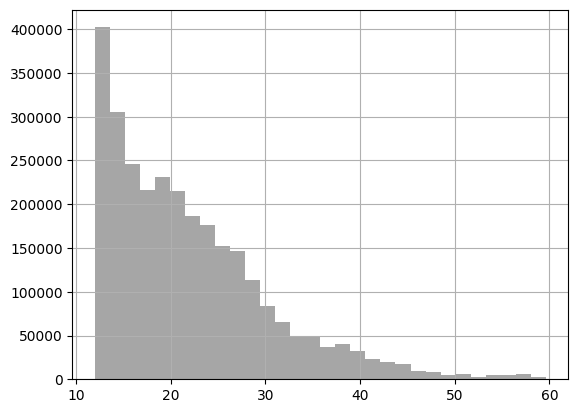

In [11]:
concat_df[concat_df['TotalDisplacement'].between(12, 60)]['TotalDisplacement'].hist(bins=30, color='gray', alpha=0.7)

In [12]:
df_normal['UniqueTrialID'].nunique()

4577

/var/folders/fp/69w3242x183607ffnzm682500000gp/T/ipykernel_6519/2299745376.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


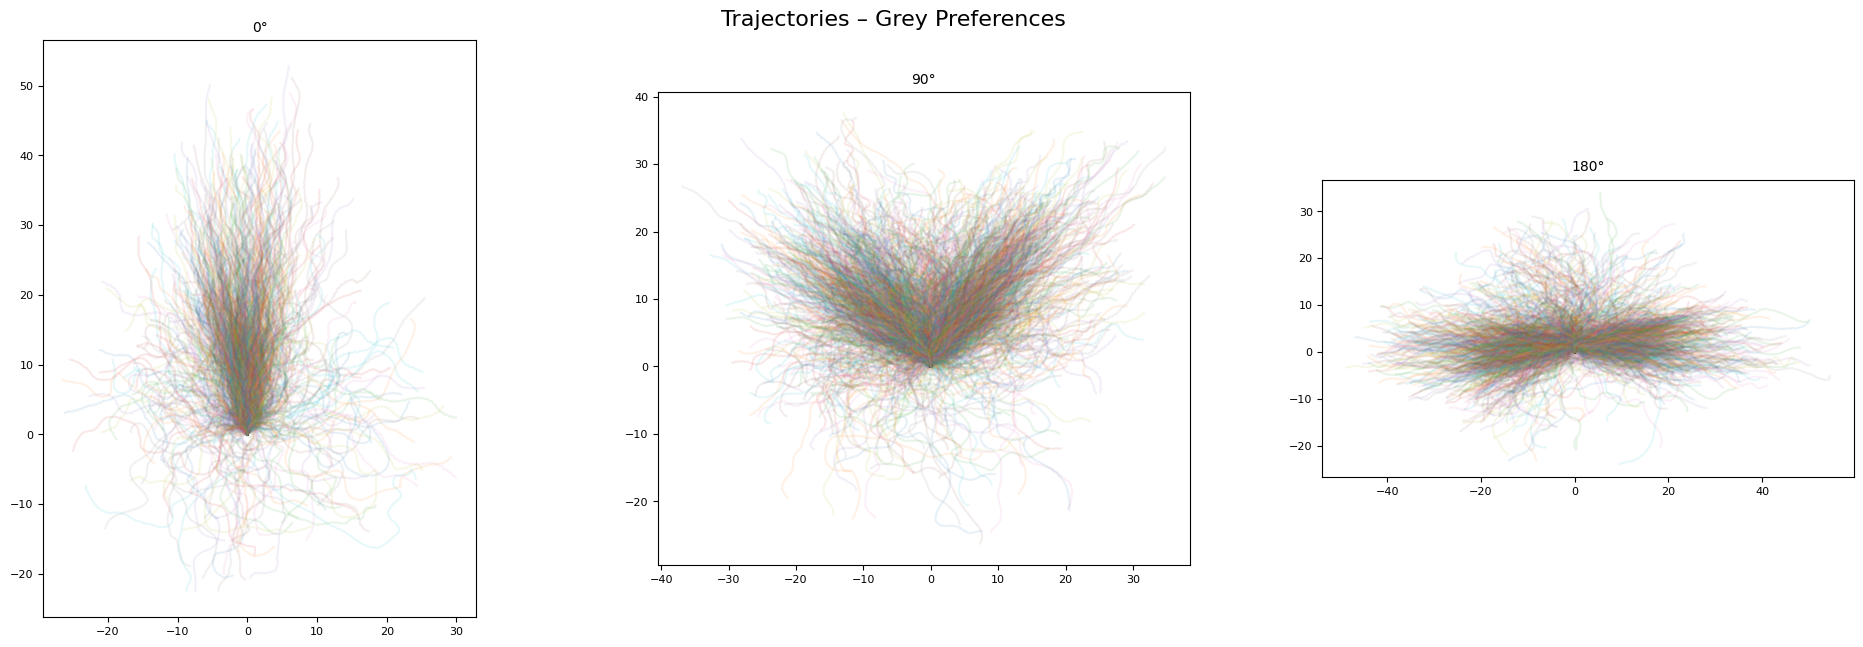

In [13]:

#add angle column to df_joined
df_normal['Angle'] = df_normal['stepName'].apply(lambda x: parse_angle_from_config(x, default_angle=999.0))
# -----------------------------------------------------------------
#  Trajectories for all configs
#  shown in a grid, one panel per Angle
# -----------------------------------------------------------------
import math, re
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec

# 1.  The joined dataframe is assumed to exist:  df_normal

df_filt = df_normal

# make sure Angle is numeric so the sort works
df_filt['Angle'] = pd.to_numeric(df_filt['Angle'], errors='coerce')

angles = sorted(df_filt['Angle'].dropna().unique())
if not angles:
    raise ValueError("No matching configs with an Angle column found.")

# 3.  Build grid layout -----------------------------------------------------
n_panels = len(angles)
n_cols   = 3                               # change to taste
n_rows   = math.ceil(n_panels / n_cols)

fig = plt.figure(figsize=(n_cols*8, n_rows*7.5))
gs  = gridspec.GridSpec(n_rows, n_cols, wspace=.25, hspace=.35)

# 4.  One sub-plot per Angle -------------------------------------------------
for idx, angle in enumerate(angles):
    ax = fig.add_subplot(gs[idx])
    g  = df_filt[df_filt['Angle'] == angle]

    # trajectories
    for trial_id, td in g.groupby('UniqueTrialID'):
        ax.plot(td['GameObjectPosX'], td['GameObjectPosZ'], alpha=.1)

    # basic aesthetics
    #ax.set_xlim(-40, 40)
    #ax.set_ylim(-10, 70)
    ax.set_aspect('equal', adjustable='box')

    #ax.set_xticks([-60, -40, -20, 0, 20, 40, 60])
    #ax.set_yticks([0, 20, 40, 60])
    ax.tick_params(labelsize=8)

    ax.set_title(f"{int(angle)}°", fontsize=10)


# hide any leftover empty cells
for j in range(idx+1, n_rows*n_cols):
    fig.add_subplot(gs[j]).axis('off')

fig.suptitle("Trajectories – Grey Preferences", y=.92, fontsize=16)
plt.tight_layout()
plt.show()

In [14]:
df_normal.columns

Index(['Current Time', 'VR', 'Scene', 'CurrentSequenceScene', 'ConfigFile',
       'CurrentTrial', 'CurrentStep', 'GameObjectPosX', 'GameObjectPosY',
       'GameObjectPosZ', 'GameObjectRotX', 'GameObjectRotY', 'GameObjectRotZ',
       'SensPosX', 'SensPosY', 'SensPosZ', 'SensRotX', 'SensRotY', 'SensRotZ',
       'stepIndex', 'stepName', 'SourceFile', 'elapsed_time',
       'ExperimenterName', 'Comments', 'FlyID', 'UniqueTrialID', 'delta_x',
       'delta_y', 'delta_z', 'step_distance', 'TotalDisplacement',
       'TravelDirectionDeg', 'TotalPathLength', 'trial_time', 'Angle'],
      dtype='object')

In [15]:
df_normal['stepName'].unique()

array(['StaticSolo_40_0deg', 'StaticChoice_80_40_90deg',
       'StaticChoice_00_40_180deg', 'StaticChoice_80_40_180deg',
       'StaticChoice_40_80_90deg', 'StaticChoice_40_00_180deg',
       'StaticSolo_00_0deg', 'StaticChoice_40_40_90deg',
       'StaticSolo_20_0deg', 'StaticSolo_60_0deg',
       'StaticChoice_60_40_90deg', 'StaticChoice_40_40_180deg',
       'StaticChoice_40_60_180deg', 'StaticChoice_40_20_180deg',
       'StaticChoice_20_40_180deg', 'StaticChoice_20_40_90deg',
       'StaticChoice_40_80_180deg', 'StaticChoice_60_40_180deg',
       'StaticChoice_40_20_90deg', 'StaticSolo_80_0deg',
       'StaticChoice_40_00_90deg', 'StaticChoice_00_40_90deg',
       'StaticChoice_40_60_90deg'], dtype=object)

In [16]:
import re

def parse_step_name(name):
    match = re.search(r'_(\d{2})_(\d{2})_(\d{2,3})deg$', name)
    if match:
        shade1, shade2, angle = match.groups()
        return int(shade1), int(shade2), int(angle)
    else:
        return None, None, None

df_normal[['shade1', 'shade2', 'conflict_angle']] = df_normal['stepName'].apply(
    lambda x: pd.Series(parse_step_name(x))
)
trial_summary = (
    df_normal
      .sort_values(['UniqueTrialID', 'elapsed_time'])
      .groupby('UniqueTrialID')
      .agg(
          FlyID=('FlyID', 'first'),
          stepName=('stepName', 'first'),
          conflict_angle=('conflict_angle', 'first'),
          shade1=('shade1', 'first'),
          shade2=('shade2', 'first'),
          travel_dir=('TravelDirectionDeg', 'first')
      )
      .dropna(subset=['travel_dir'])
      .reset_index()
)

# Convert to signed
trial_summary['travel_dir_signed'] = (
    (trial_summary['travel_dir'] + 180) % 360 - 180
)
def extract_non_40_shade(row):
    if row['shade1'] == 40 and row['shade2'] == 40:
        return [40]  # will duplicate later
    elif row['shade1'] == 40:
        return [row['shade2']]
    elif row['shade2'] == 40:
        return [row['shade1']]
    else:
        return []  # exclude anything else?

# Expand rows with multiple non-40 values
trial_summary['non_40_shade'] = trial_summary.apply(extract_non_40_shade, axis=1)
trial_summary = trial_summary.explode('non_40_shade').dropna(subset=['non_40_shade'])
def get_40_side(row):
    if row['shade1'] == 40 and row['shade2'] == 40:
        return 'both'
    elif row['shade1'] == 40:
        return 'shade1'
    elif row['shade2'] == 40:
        return 'shade2'
    else:
        return 'none'

trial_summary['forty_side'] = trial_summary.apply(get_40_side, axis=1)


In [17]:
trial_summary['stepName'].value_counts()


stepName
StaticChoice_40_40_180deg    367
StaticChoice_40_40_90deg     342
StaticChoice_80_40_90deg     202
StaticChoice_40_80_90deg     198
StaticChoice_40_00_90deg     194
StaticChoice_40_20_90deg     193
StaticChoice_00_40_180deg    191
StaticChoice_20_40_90deg     190
StaticChoice_20_40_180deg    188
StaticChoice_40_00_180deg    188
StaticChoice_40_20_180deg    186
StaticChoice_60_40_90deg     183
StaticChoice_00_40_90deg     181
StaticChoice_40_60_90deg     178
StaticChoice_40_60_180deg    177
StaticChoice_40_80_180deg    167
StaticChoice_80_40_180deg    166
StaticChoice_60_40_180deg    163
Name: count, dtype: int64

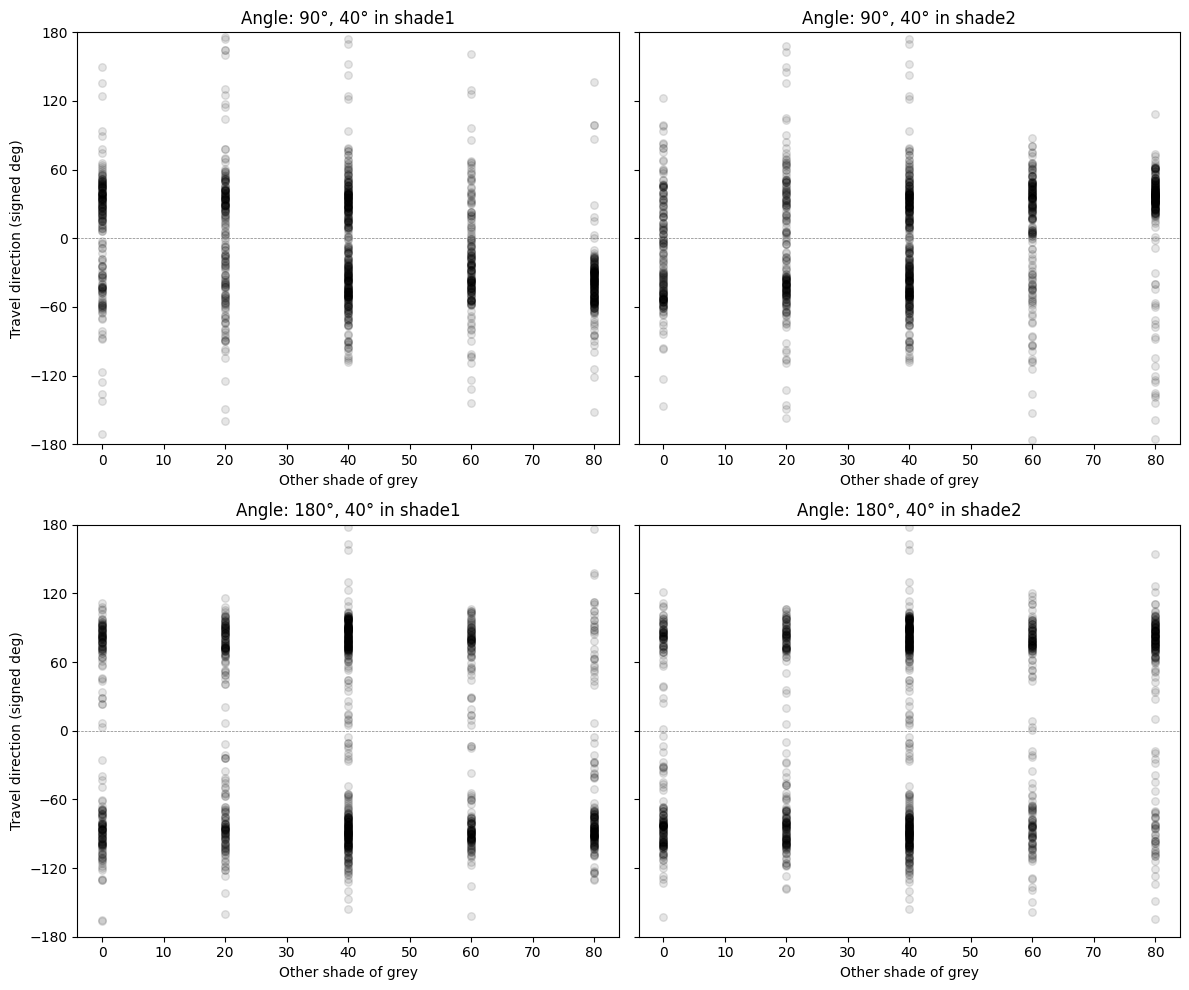

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
angle_order = [90, 180]
side_order = ['shade1', 'shade2']

for i, angle in enumerate(angle_order):
    for j, side in enumerate(side_order):
        ax = axes[i, j]
        subset = trial_summary[
            (trial_summary['conflict_angle'] == angle) &
            ((trial_summary['forty_side'] == side) | (trial_summary['forty_side'] == 'both'))
        ]
        ax.scatter(subset['non_40_shade'], subset['travel_dir_signed'], 
                   color='black', alpha=0.1, s=30)
        ax.axhline(0, color='grey', ls='--', lw=0.5)
        ax.set_title(f'Angle: {angle}°, 40° in {side}')
        ax.set_xlabel('Other shade of grey')
        ax.set_ylim(-180, 180)
        ax.set_yticks(range(-180, 181, 60))

axes[0,0].set_ylabel('Travel direction (signed deg)')
axes[1,0].set_ylabel('Travel direction (signed deg)')
plt.tight_layout()
plt.show()


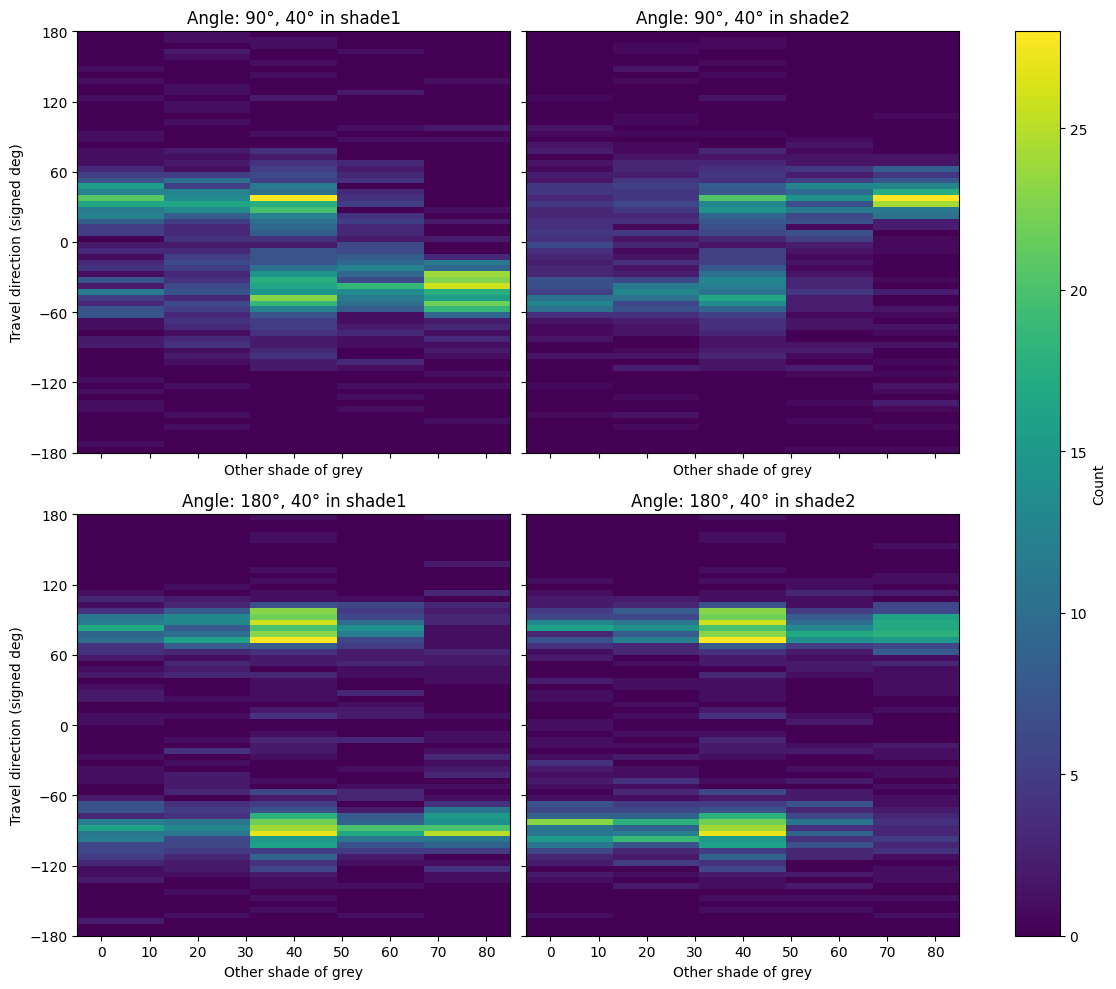

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Define bins
x_bins = sorted(trial_summary['non_40_shade'].dropna().unique())
y_bins = np.linspace(-180, 180, 73)  # 10° bins (adjustable)

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
angle_order = [90, 180]
side_order = ['shade1', 'shade2']

for i, angle in enumerate(angle_order):
    for j, side in enumerate(side_order):
        ax = axes[i, j]

        # Filter data for this subplot
        subset = trial_summary[
            (trial_summary['conflict_angle'] == angle) &
            ((trial_summary['forty_side'] == side) | (trial_summary['forty_side'] == 'both'))
        ]

        # Prepare 2D histogram matrix
        hist = np.zeros((len(y_bins) - 1, len(x_bins)))

        for xi, shade in enumerate(x_bins):
            shade_data = subset[subset['non_40_shade'] == shade]['travel_dir_signed']
            hist[:, xi], _ = np.histogram(shade_data, bins=y_bins)

        # Show as image
        im = ax.imshow(
            hist, aspect='auto', origin='lower',
            extent=[min(x_bins) - 5, max(x_bins) + 5, -180, 180],
            cmap='viridis'
        )

        ax.set_title(f'Angle: {angle}°, 40° in {side}')
        ax.set_xlabel('Other shade of grey')
        ax.set_yticks(range(-180, 181, 60))

axes[0,0].set_ylabel('Travel direction (signed deg)')
axes[1,0].set_ylabel('Travel direction (signed deg)')
plt.tight_layout()
plt.colorbar(im, ax=axes, orientation='vertical', label='Count')
plt.show()


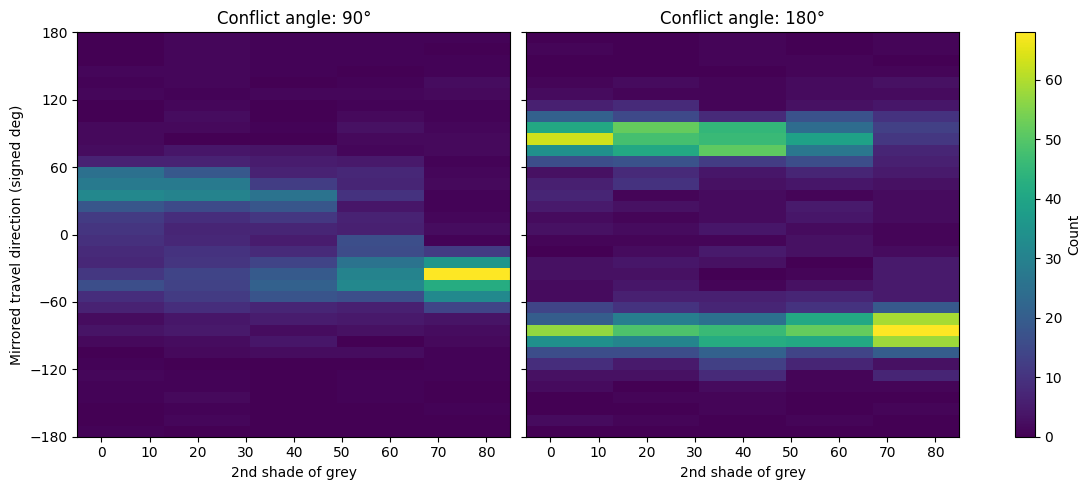

In [20]:
# Copy to avoid mutating original
df_mirror = trial_summary.copy()

# Mirror the travel direction for shade2 trials
df_mirror['travel_dir_mirrored'] = df_mirror.apply(
    lambda row: -row['travel_dir_signed'] if row['forty_side'] == 'shade2' else row['travel_dir_signed'],
    axis=1
)

# Only keep trials where 40 is in shade1, shade2 (mirrored), or both
df_mirror = df_mirror[df_mirror['forty_side'].isin(['shade1', 'shade2', 'both'])]

# Define bins
x_bins = sorted(df_mirror['non_40_shade'].dropna().unique())
y_bins = np.linspace(-180, 180, 37)  # 10° bins

# One plot per angle now
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
angle_order = [90, 180]

for i, angle in enumerate(angle_order):
    ax = axes[i]

    subset = df_mirror[df_mirror['conflict_angle'] == angle]

    # Initialize histogram matrix
    hist = np.zeros((len(y_bins) - 1, len(x_bins)))

    for xi, shade in enumerate(x_bins):
        shade_data = subset[subset['non_40_shade'] == shade]['travel_dir_mirrored']
        hist[:, xi], _ = np.histogram(shade_data, bins=y_bins)

        # Normalize each column (shade) by its own max
    #hist_max = hist.max(axis=0, keepdims=True)
    #hist_max[hist_max == 0] = 1  # Avoid division by zero
    #hist /= hist_max
    
    im = ax.imshow(
        hist, aspect='auto', origin='lower',
        extent=[min(x_bins) - 5, max(x_bins) + 5, -180, 180],
        cmap='viridis'
    )

    ax.set_title(f'Conflict angle: {angle}°')
    ax.set_xlabel('2nd shade of grey')
    ax.set_yticks(range(-180, 181, 60))
    ax.grid(False)

axes[0].set_ylabel('Mirrored travel direction (signed deg)')
plt.tight_layout()
plt.colorbar(im, ax=axes, orientation='vertical', label='Count')
plt.show()


In [21]:
# Assign preference (1 = shade 2, 0 = shade 1)
df_mirror['shade2_choice'] = df_mirror['travel_dir_mirrored'] > 0

from statsmodels.stats.proportion import proportion_confint

# Step 1: Group and calculate counts and proportions
pref_summary = (
    df_mirror
    .groupby(['conflict_angle', 'non_40_shade'])
    .agg(
        n=('shade2_choice', 'count'),
        proportion=('shade2_choice', 'mean')
    )
    .reset_index()
)

# Step 2: Calculate Wilson confidence intervals for binomial proportion
# Note: need number of "successes" = proportion * n
pref_summary['ci_low'], pref_summary['ci_high'] = zip(*pref_summary.apply(
    lambda row: proportion_confint(count=int(row['proportion'] * row['n']),
                                   nobs=int(row['n']),
                                   method='wilson'),
    axis=1
))


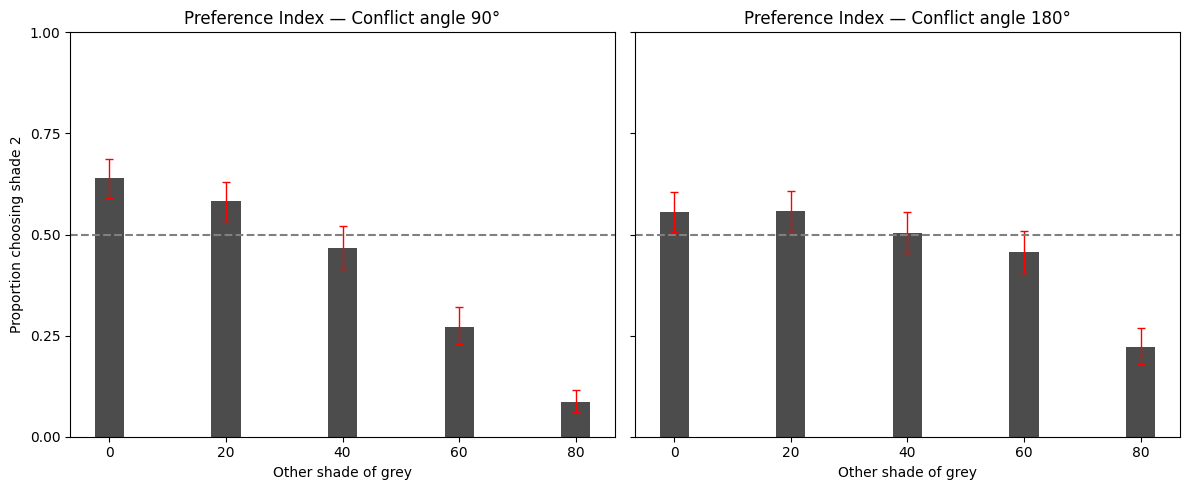

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
angle_order = [90, 180]

for i, angle in enumerate(angle_order):
    ax = axes[i]

    subset = pref_summary[pref_summary['conflict_angle'] == angle]

    # Plot bar centers
    ax.bar(subset['non_40_shade'], subset['proportion'], width=5, color='black', alpha=0.7)

    # Plot error bars
    ax.errorbar(
        subset['non_40_shade'],
        subset['proportion'],
        yerr=[subset['proportion'] - subset['ci_low'], subset['ci_high'] - subset['proportion']],
        fmt='none',
        ecolor='red',
        capsize=3,
        elinewidth=1,
    )

    ax.axhline(0.5, color='gray', ls='--')  # neutral line
    ax.set_title(f'Preference Index — Conflict angle {angle}°')
    ax.set_xlabel('Other shade of grey')
    ax.set_ylim(0, 1)
    ax.set_xticks(sorted(df_mirror['non_40_shade'].unique()))
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    if i == 0:
        ax.set_ylabel('Proportion choosing shade 2')

plt.tight_layout()
plt.show()


In [23]:
# Step 2: Group by FlyID, conflict angle, and shade
fly_pref = (
    df_mirror
    .groupby(['FlyID', 'conflict_angle', 'non_40_shade'])
    .agg(
        proportion=('shade2_choice', 'mean'),
        n=('shade2_choice', 'count')
    )
    .reset_index()
)
from statsmodels.stats.proportion import proportion_confint

# Calculate Wilson CIs for each fly's dot
fly_pref['ci_low'], fly_pref['ci_high'] = zip(*fly_pref.apply(
    lambda row: proportion_confint(count=int(row['proportion'] * row['n']),
                                   nobs=int(row['n']),
                                   method='wilson'),
    axis=1
))


/var/folders/fp/69w3242x183607ffnzm682500000gp/T/ipykernel_6519/1088717734.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['x_pos'] = subset['non_40_shade'].map(x_pos_map)
/var/folders/fp/69w3242x183607ffnzm682500000gp/T/ipykernel_6519/1088717734.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['x_pos'] = subset['non_40_shade'].map(x_pos_map)


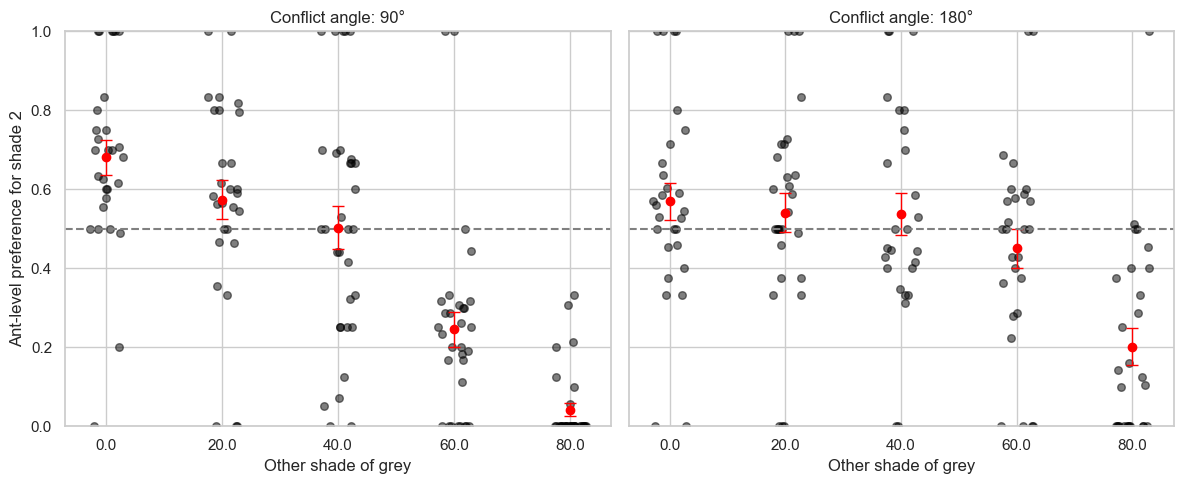

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style='whitegrid')

# Get sorted numeric list of shades
x_shades = sorted(fly_pref['non_40_shade'].dropna().unique())

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
angle_order = [90, 180]

for i, angle in enumerate(angle_order):
    ax = axes[i]
    subset = fly_pref[fly_pref['conflict_angle'] == angle]

    # Convert x values to numeric positions
    x_pos_map = {shade: xi for xi, shade in enumerate(x_shades)}
    subset['x_pos'] = subset['non_40_shade'].map(x_pos_map)

    # Plot individual dots with jitter around numeric positions
    jitter_strength = 0.15
    jittered_x = subset['x_pos'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(subset))

    ax.scatter(
        jittered_x,
        subset['proportion'],
        alpha=0.5,
        s=30,
        color='black'
    )

    # Compute group-level stats
    group_stats = (
        subset.groupby('non_40_shade')
              .agg(mean=('proportion', 'mean'),
                   sem=('proportion', lambda x: x.std() / (len(x)**0.5)))
              .reset_index()
    )
    group_stats['x_pos'] = group_stats['non_40_shade'].map(x_pos_map)

    # Overlay error bars
    ax.errorbar(
        group_stats['x_pos'],
        group_stats['mean'],
        yerr=group_stats['sem'],
        fmt='o',
        color='red',
        capsize=4,
        lw=1
    )

    # Set axis labels and ticks
    ax.set_xticks(range(len(x_shades)))
    ax.set_xticklabels(x_shades)
    ax.axhline(0.5, color='gray', ls='--')
    ax.set_title(f'Conflict angle: {angle}°')
    ax.set_xlabel('Other shade of grey')
    if i == 0:
        ax.set_ylabel('Ant-level preference for shade 2')
    else:
        ax.set_ylabel('')
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


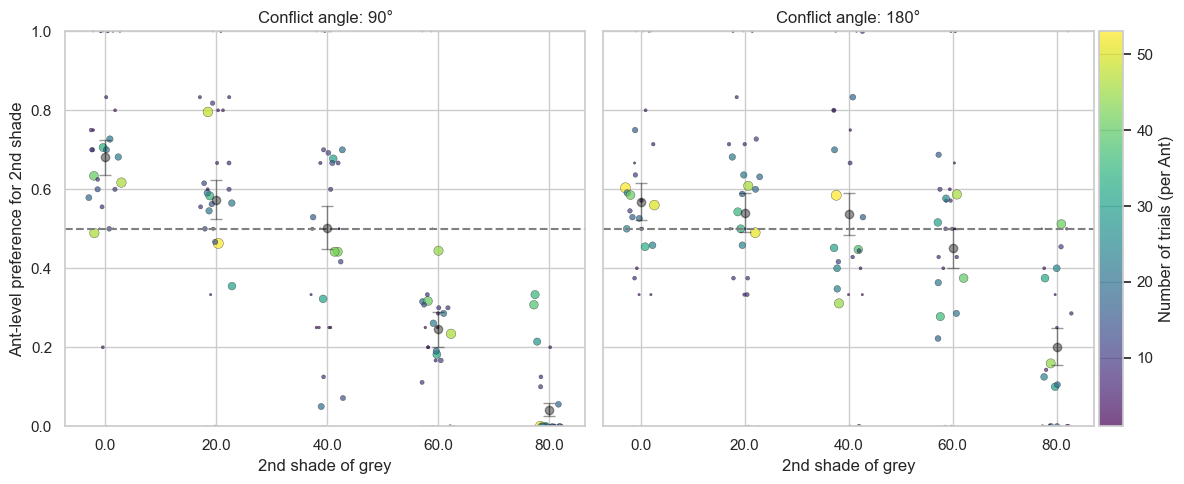

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style='whitegrid')

x_shades = sorted(fly_pref['non_40_shade'].dropna().unique())
x_pos_map = {shade: xi for xi, shade in enumerate(x_shades)}

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
angle_order = [90, 180]

for i, angle in enumerate(angle_order):
    ax = axes[i]
    subset = fly_pref[fly_pref['conflict_angle'] == angle].copy()
    subset['x_pos'] = subset['non_40_shade'].map(x_pos_map)

    # Jitter
    jitter_strength = 0.15
    subset['jittered_x'] = subset['x_pos'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(subset))

    # Plot individual dots, colored by number of trials
    sc = ax.scatter(
        subset['jittered_x'],
        subset['proportion'],
        c=subset['n'],
        s=subset['n'],             # size = number of trials
        cmap='viridis',            # or 'plasma', 'magma', etc.
        alpha=0.7,
        edgecolor='k',
        linewidth=0.3
    )

    # Group-level stats (optional overlay)
    group_stats = (
        subset.groupby('non_40_shade')
              .agg(mean=('proportion', 'mean'),
                   sem=('proportion', lambda x: x.std() / (len(x)**0.5)))
              .reset_index()
    )
    group_stats['x_pos'] = group_stats['non_40_shade'].map(x_pos_map)

    ax.errorbar(
        group_stats['x_pos'],
        group_stats['mean'],
        yerr=group_stats['sem'],
        fmt='o',
        color='black',
        capsize=4,
        lw=1,
        alpha=0.4
    )

    ax.set_xticks(range(len(x_shades)))
    ax.set_xticklabels(x_shades)
    ax.axhline(0.5, color='gray', ls='--')
    ax.set_title(f'Conflict angle: {angle}°')
    ax.set_xlabel('2nd shade of grey')
    if i == 0:
        ax.set_ylabel('Ant-level preference for 2nd shade')
    ax.set_ylim(0, 1)

# Create colorbar axis to the right of all subplots
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(axes[-1])
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(sc, cax=cax)
cbar.set_label('Number of trials (per Ant)')

plt.tight_layout()
plt.show()

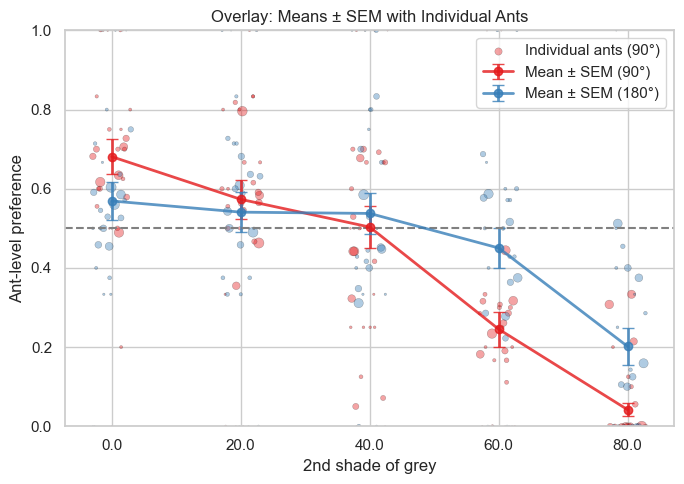

In [31]:
# Create new figure for overlayed plot
fig_overlay, ax_overlay = plt.subplots(figsize=(7, 5))

colors = sns.color_palette("Set1", n_colors=2)
angle_labels = {90: "90°", 180: "180°"}

for i, angle in enumerate(angle_order):
    subset = fly_pref[fly_pref['conflict_angle'] == angle].copy()
    subset['x_pos'] = subset['non_40_shade'].map(x_pos_map)
    
    # Add jitter
    jitter_strength = 0.15
    subset['jittered_x'] = subset['x_pos'] + np.random.uniform(
        -jitter_strength, jitter_strength, size=len(subset)
    )
    
    # Plot individual ants, colored by angle, size by n
    ax_overlay.scatter(
        subset['jittered_x'],
        subset['proportion'],
        s=subset['n'],  # size = number of trials
        color=colors[i],
        alpha=0.4,
        edgecolor='k',
        linewidth=0.3,
        label=f'Individual ants ({angle_labels[angle]})' if i == 0 else None
    )

    # Group stats
    group_stats = (
        subset.groupby('non_40_shade')
              .agg(mean=('proportion', 'mean'),
                   sem=('proportion', lambda x: x.std() / (len(x)**0.5)))
              .reset_index()
    )
    group_stats['x_pos'] = group_stats['non_40_shade'].map(x_pos_map)

    # Plot mean ± SEM
    ax_overlay.errorbar(
        group_stats['x_pos'],
        group_stats['mean'],
        yerr=group_stats['sem'],
        fmt='-o',
        color=colors[i],
        label=f'Mean ± SEM ({angle_labels[angle]})',
        capsize=4,
        lw=2,
        alpha=0.8
    )

# Decorations
ax_overlay.set_xticks(range(len(x_shades)))
ax_overlay.set_xticklabels(x_shades)
ax_overlay.axhline(0.5, color='gray', ls='--')
ax_overlay.set_xlabel('2nd shade of grey')
ax_overlay.set_ylabel('Ant-level preference')
ax_overlay.set_title('Overlay: Means ± SEM with Individual Ants')
ax_overlay.set_ylim(0, 1)
ax_overlay.legend()

plt.tight_layout()
plt.show()


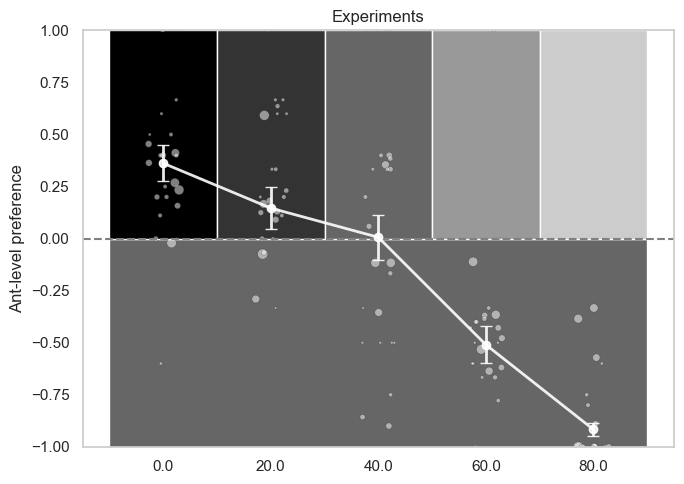

In [55]:
# Create new figure for overlayed plot
fig_overlay, ax_overlay = plt.subplots(figsize=(7, 5))

colors = sns.color_palette("Set1", n_colors=2)
angle_labels = {90: "90°"}

subset = fly_pref[fly_pref['conflict_angle'] == 90].copy()
subset['x_pos'] = subset['non_40_shade'].map(x_pos_map)

# Add jitter
jitter_strength = 0.15
subset['jittered_x'] = subset['x_pos'] + np.random.uniform(
    -jitter_strength, jitter_strength, size=len(subset)
)
# Rescale preference: 0 → 1  becomes  -1 → 1
subset['rescaled'] = 2 * subset['proportion'] - 1
# ---- Background greys ----
greys = [0.0, 0.2, 0.4, 0.6, 0.8]
n = len(x_shades)

# Make sure the axis runs from -1 to 1 so 0 is exactly mid-height
ax_overlay.set_ylim(-1, 1)

# Bottom half: uniform grey 0.4 across the full x-range
ax_overlay.axhspan(-1, 0, xmin=0.045, xmax=0.955, facecolor=str(0.4), zorder=0)

# Top half: per-category vertical bands with given greys
# Each category i occupies [i-0.5, i+0.5] along x
for i, g in enumerate(greys):
    ax_overlay.axvspan(i - 0.5, i + 0.5, ymin=0.5, ymax=1.0,
                       facecolor=str(g), zorder=0)


# Plot individual ants (rescaled)
ax_overlay.scatter(
    subset['jittered_x'],
    subset['rescaled'],
    s=subset['n'],
    color="white",
    alpha=0.5,
    edgecolor='k',
    linewidth=0.3,
    #label=f'Individual ants' if i == 0 else None
)

# Group stats on rescaled values
group_stats = (
    subset.groupby('non_40_shade')
            .agg(mean=('rescaled', 'mean'),
                 sem=('rescaled', lambda x: x.std() / (len(x)**0.5)))
            .reset_index()
)
group_stats['x_pos'] = group_stats['non_40_shade'].map(x_pos_map)

# Plot mean ± SEM (rescaled)
ax_overlay.errorbar(
    group_stats['x_pos'],
    group_stats['mean'],
    yerr=group_stats['sem'],
    fmt='-o',
    color="white",
    label=f'Mean ± SEM ',
    capsize=4,
    lw=2,
    alpha=0.9
)

# Decorations (updated for -1 → 1 scale)
ax_overlay.set_xticks(range(len(x_shades)))
ax_overlay.set_xticklabels(x_shades)
ax_overlay.axhline(0, color='gray', ls='--')  # now baseline is 0
#ax_overlay.set_xlabel('2nd shade of grey')
ax_overlay.set_ylabel('Ant-level preference')
ax_overlay.set_title('Experiments')
ax_overlay.set_ylim(-1, 1)  # new limits
#ax_overlay.legend()
ax_overlay.grid(False)  # remove grid for cleaner look

plt.tight_layout()
plt.show()


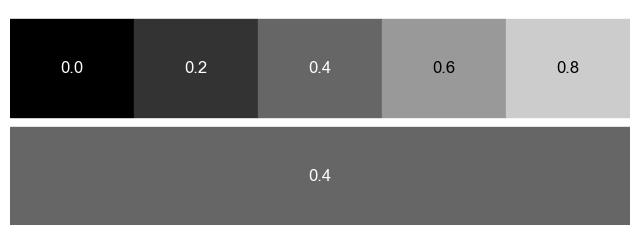

In [27]:
import matplotlib.pyplot as plt

# Grey levels
greys = [0.0, 0.2, 0.4, 0.6, 0.8]
n = len(greys)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 2.8))

# Vertical positions
top_y = 1.1  # Top row y-position
bottom_y = 0  # Bottom rectangle y-position
rect_height = 1  # Height of both rows

# Top row: individual grey rectangles
for i, g in enumerate(greys):
    ax.add_patch(plt.Rectangle((i, top_y), 1, rect_height, color=str(g)))
    ax.text(i + 0.5, top_y + rect_height / 2, str(g),
            va='center', ha='center',
            fontsize=12, color='white' if g < 0.5 else 'black')

# Bottom rectangle: same total width, centered label
bottom_shade = 0.4
ax.add_patch(plt.Rectangle((0, bottom_y), n, rect_height, color=str(bottom_shade)))
ax.text(n / 2, bottom_y + rect_height / 2, str(bottom_shade),
        va='center', ha='center',
        fontsize=12, color='white' if bottom_shade < 0.5 else 'black')

# Set limits and remove axes
ax.set_xlim(0, n)
ax.set_ylim(0, top_y + rect_height + 0.1)
ax.axis('off')

plt.show()


/var/folders/fp/69w3242x183607ffnzm682500000gp/T/ipykernel_6519/4288586586.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


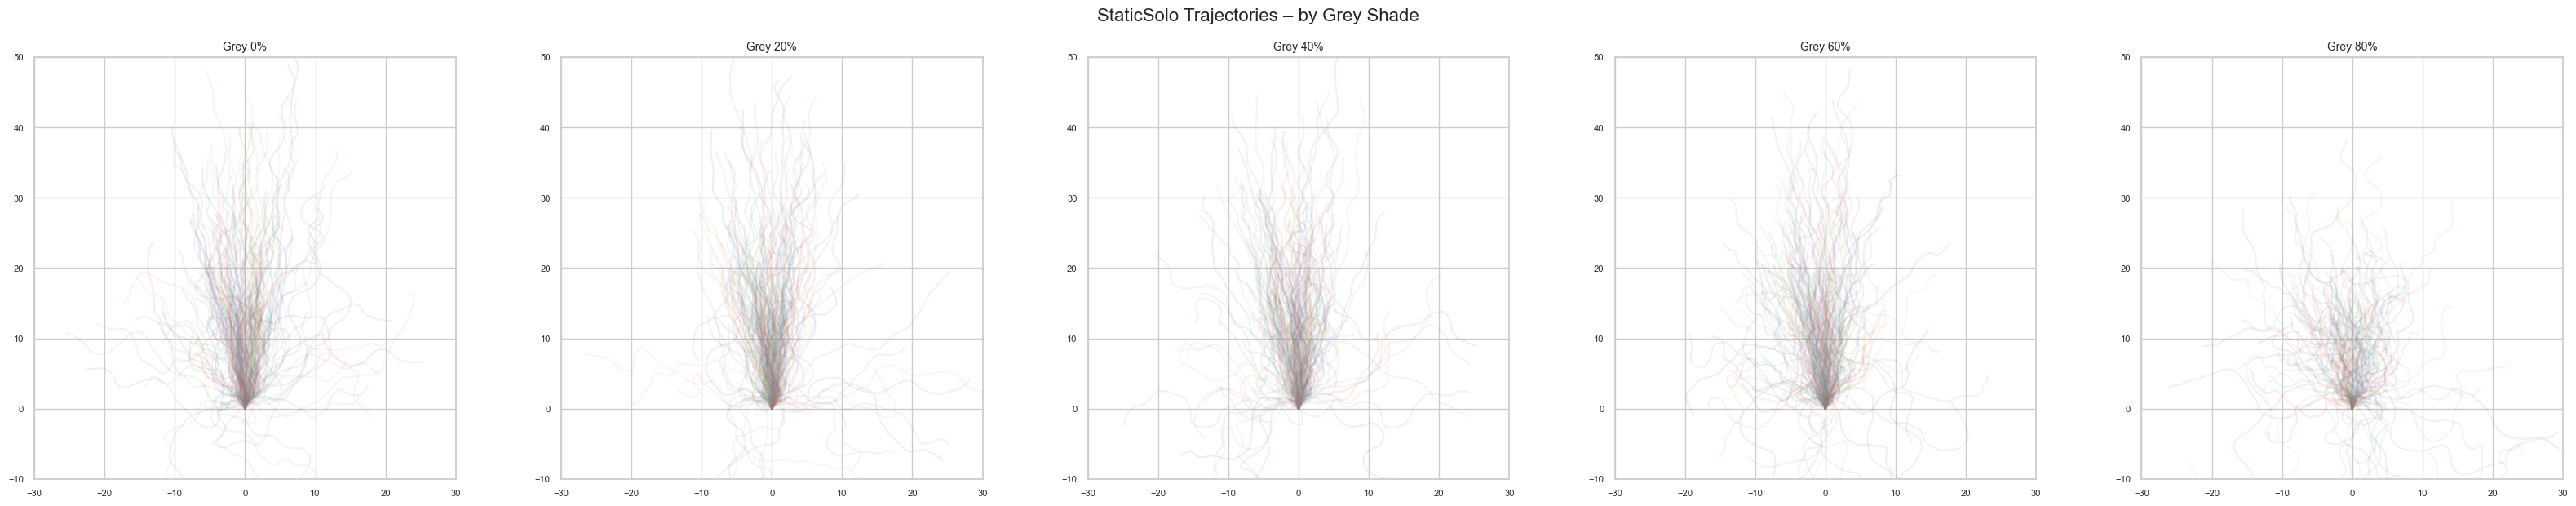

In [28]:
import math, re
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec

# 1. Filter for StaticSolo experiments
df_solo = df_normal[df_normal['stepName'].str.startswith('StaticSolo')].copy()

# 2. Extract GreyShade from stepName
def extract_grey(step):
    match = re.match(r'StaticSolo_(\d+)_\d+deg', step)
    return int(match.group(1)) if match else None

df_solo['Grey'] = df_solo['stepName'].apply(extract_grey)

# Drop any rows with missing Grey value
df_solo = df_solo.dropna(subset=['Grey'])

# 3. Determine unique shades and grid size
grey_shades = sorted(df_solo['Grey'].unique())
n_panels = len(grey_shades)
n_cols = 5
n_rows = math.ceil(n_panels / n_cols)

# 4. Setup figure
fig = plt.figure(figsize=(n_cols * 8, n_rows * 7.5))
gs = gridspec.GridSpec(n_rows, n_cols, wspace=.25, hspace=.35)

# 5. Plot each shade
for idx, grey in enumerate(grey_shades):
    ax = fig.add_subplot(gs[idx])
    g = df_solo[df_solo['Grey'] == grey]

    for trial_id, td in g.groupby('UniqueTrialID'):
        ax.plot(td['GameObjectPosX'], td['GameObjectPosZ'], alpha=0.1)

    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(labelsize=8)
    ax.set_title(f"Grey {grey}%", fontsize=10)
    ax.set_ylim(-10,50)
    ax.set_xlim(-30,30)
# 6. Hide unused subplots
for j in range(idx + 1, n_rows * n_cols):
    fig.add_subplot(gs[j]).axis('off')

fig.suptitle("StaticSolo Trajectories – by Grey Shade", y=.92, fontsize=16)
plt.tight_layout()
plt.show()


In [29]:
trial_counts = df_normal.groupby('FlyID')['UniqueTrialID'].nunique().reset_index()
trial_counts = trial_counts.rename(columns={'UniqueTrialID': 'NumTrials'})
print(trial_counts)


     FlyID  NumTrials
0   k3ggcy          9
1   k3kbkg        137
2   k3kbmb          8
3   k3kcmg         25
4   k3kcrg         35
5   k3kcwg          1
6   k3kcyg        556
7   k3kkcb          7
8   k3rcbg          1
9   k3rcgm         55
10  k3rcgw         52
11  k3rcmr        417
12  k3rcwm         11
13  k3rcyg        106
14  k3wwkm          2
15  k3wwmr         25
16  k3ycbg        251
17  k3ycwg        604
18  k4cccg        236
19  k4gbcc        271
20  k4kkbb          2
21  k4mbgm         55
22  k4mcmg        428
23  k4mcwm          4
24  k4mkww         43
25  k4mmbb         86
26  k4rrmm        293
27  k4ycbm         98
28  k4yccy        137
29  k4yckg          2
30  k4ycmb          1
31  k4ycmg         31
32  k4ycmy        168
33  k4ycyb        195
34  k5cgbm         78
35  k5kbcy         17
36  k5kcrm         97
37  k5kcyy         33


In [30]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import math

# Copy and prepare data
df = df_solo.copy()
df['travel_dir_rad'] = np.deg2rad(df['TravelDirectionWrapped'])

directedness = df.groupby('FlyID').apply(
    lambda x: np.abs(np.mean(np.exp(1j * x['travel_dir_rad'])))
).reset_index(name='Directedness_R')


# Only keep flies with sufficient data
valid_counts = df.groupby('FlyID')['UniqueTrialID'].nunique()
valid_flies = valid_counts[valid_counts >= 11].index
directedness = directedness[directedness['FlyID'].isin(valid_flies)]

# Sort flies by directedness
directedness = directedness.sort_values('Directedness_R', ascending=False)
sorted_flies = directedness['FlyID'].values

# Grid layout
n = len(sorted_flies)
n_cols = 4
n_rows = math.ceil(n / n_cols)

fig = plt.figure(figsize=(n_cols * 4, n_rows * 4))
gs = gridspec.GridSpec(n_rows, n_cols, wspace=0.3, hspace=0.4)

for idx, fly in enumerate(sorted_flies):
    ax = fig.add_subplot(gs[idx])
    g = df[df['FlyID'] == fly]

    for trial_id, td in g.groupby('UniqueTrialID'):
        ax.plot(td['GameObjectPosX'], td['GameObjectPosZ'], alpha=0.2)

    R = directedness.loc[directedness['FlyID'] == fly, 'Directedness_R'].values[0]
    ax.set_title(f"Fly {fly}  |  R = {R:.2f}", fontsize=10)
    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(labelsize=6)

# Hide any unused axes
for j in range(idx+1, n_rows*n_cols):
    fig.add_subplot(gs[j]).axis('off')

fig.suptitle("Trajectories by Fly (Sorted by Directedness)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


KeyError: 'TravelDirectionWrapped'

/var/folders/fp/69w3242x183607ffnzm682500000gp/T/ipykernel_10846/625918452.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


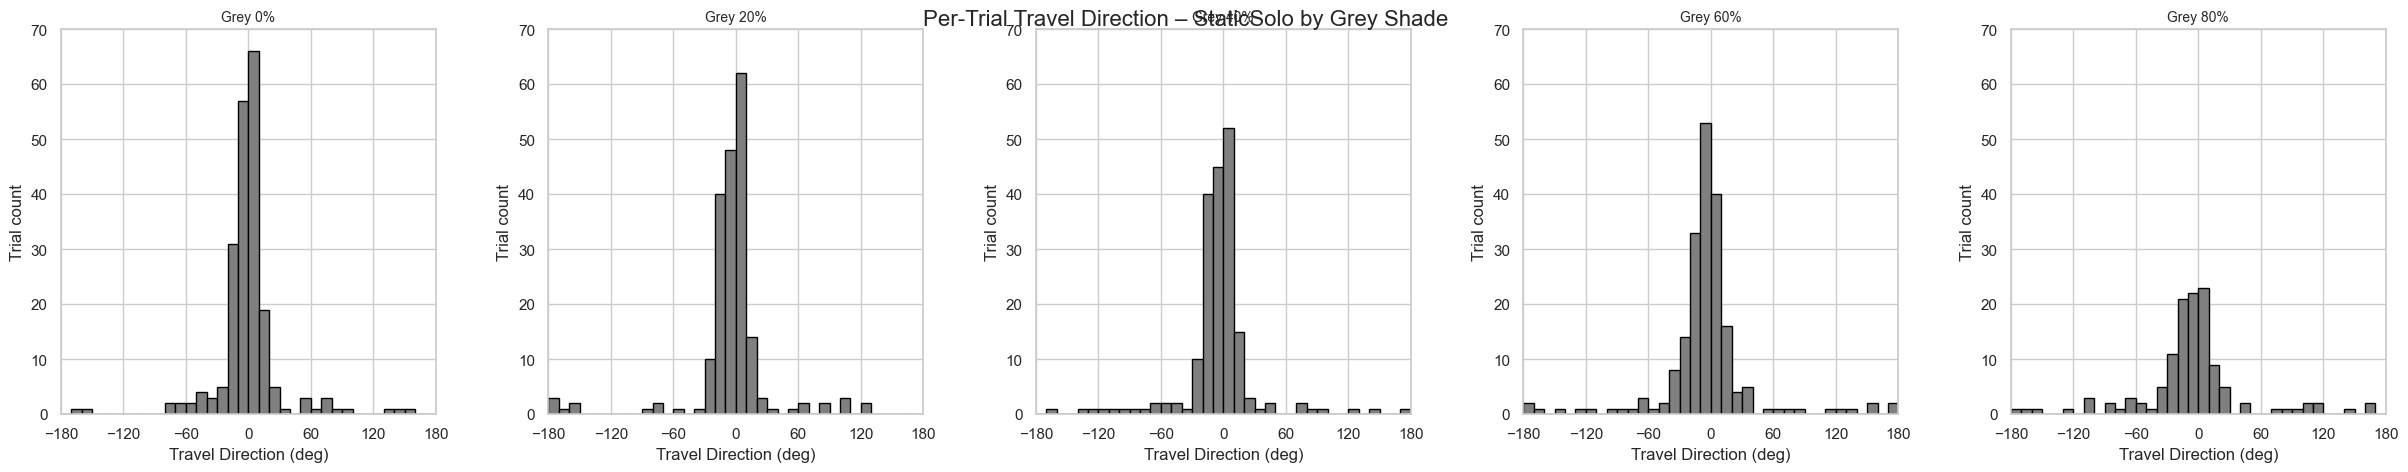

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Filter StaticSolo and extract grey
df_solo = df_normal[df_normal['stepName'].str.startswith('StaticSolo')].copy()

def extract_grey(step):
    match = re.match(r'StaticSolo_(\d+)_\d+deg', step)
    return int(match.group(1)) if match else None

df_solo['Grey'] = df_solo['stepName'].apply(extract_grey)
df_solo = df_solo.dropna(subset=['Grey'])

# Wrap travel direction from [0,360] to [-180,180]
df_solo['TravelDirectionWrapped'] = ((df_solo['TravelDirectionDeg'] + 180) % 360) - 180

# Setup bins
angle_bins = np.linspace(-180, 180, 37)  # 10° bins
grey_shades = sorted(df_solo['Grey'].unique())

# Grid layout
n_panels = len(grey_shades)
n_cols = 5
n_rows = math.ceil(n_panels / n_cols)

fig = plt.figure(figsize=(n_cols * 6, n_rows * 5))
gs = gridspec.GridSpec(n_rows, n_cols, wspace=0.3, hspace=0.4)

# Plot per grey
for idx, grey in enumerate(grey_shades):
    ax = fig.add_subplot(gs[idx])

    subset = df_solo[df_solo['Grey'] == grey]

    # Compute one direction per trial (mean, median, or final — here: mean)
    per_trial_dir = (
        subset.groupby('UniqueTrialID')['TravelDirectionWrapped']
        .mean()
        .dropna()
    )

    hist, _ = np.histogram(per_trial_dir, bins=angle_bins)

    ax.bar(angle_bins[:-1], hist, width=10, align='edge', color='grey', edgecolor='black')
    ax.set_title(f'Grey {grey}%', fontsize=10)
    ax.set_xlim(-180, 180)
    ax.set_ylim(0,70)
    ax.set_xticks(range(-180, 181, 60))
    ax.set_xlabel('Travel Direction (deg)')
    ax.set_ylabel('Trial count')

# Hide extras
for j in range(idx + 1, n_rows * n_cols):
    fig.add_subplot(gs[j]).axis('off')

fig.suptitle('Per-Trial Travel Direction – StaticSolo by Grey Shade', y=.92, fontsize=16)
plt.tight_layout()
plt.show()

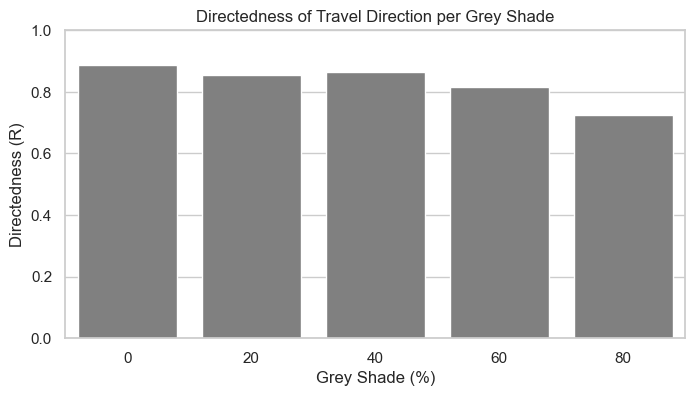

In [ ]:
import numpy as np

# Function to compute resultant vector length (R)
def compute_directedness(angles_deg):
    angles_rad = np.deg2rad(angles_deg)
    R = np.abs(np.mean(np.exp(1j * angles_rad)))
    return R

# Store results
directedness_results = []

for grey in grey_shades:
    subset = df_solo[df_solo['Grey'] == grey]

    per_trial_dir = (
        subset.groupby('UniqueTrialID')['TravelDirectionWrapped']
        .mean()
        .dropna()
    )

    R = compute_directedness(per_trial_dir)
    directedness_results.append({'Grey': grey, 'Directedness_R': R})

# Convert to DataFrame for inspection
df_directedness = pd.DataFrame(directedness_results).sort_values('Grey')

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.barplot(data=df_directedness, x='Grey', y='Directedness_R', color='gray')
plt.ylabel("Directedness (R)")
plt.xlabel("Grey Shade (%)")
plt.title("Directedness of Travel Direction per Grey Shade")
plt.ylim(0, 1)
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Extract shade from stepName
df_solo['shade'] = df_solo['stepName'].str.extract(r'StaticSolo_(\d+)_')[0].astype(int)
df_solo['travel_dir_rad'] = np.deg2rad(df_solo['TravelDirectionWrapped'])

# Minimum trials per fly-shade to include
min_trials = 3
boot_n = 1000
sample_size = 3  # or min of group size

results = []

# Group by FlyID and shade
for (fly, shade), group in df_solo.groupby(['FlyID', 'shade']):
    n_trials = group['UniqueTrialID'].nunique()
    if n_trials >= min_trials:
        # Bootstrapped directedness
        R_boot = []
        trial_groups = list(group.groupby('UniqueTrialID'))

        if len(trial_groups) >= sample_size:
            for _ in range(boot_n):
                sampled = np.random.choice(len(trial_groups), size=sample_size, replace=True)
                sample_dirs = []
                for idx in sampled:
                    sample_dirs.extend(trial_groups[idx][1]['travel_dir_rad'].values)
                R = np.abs(np.mean(np.exp(1j * np.array(sample_dirs))))
                R_boot.append(R)

            results.append({
                'FlyID': fly,
                'shade': shade,
                'mean_R': np.mean(R_boot),
                'std_R': np.std(R_boot),
                'n_trials': n_trials
            })

df_r_per_fly_shade = pd.DataFrame(results)


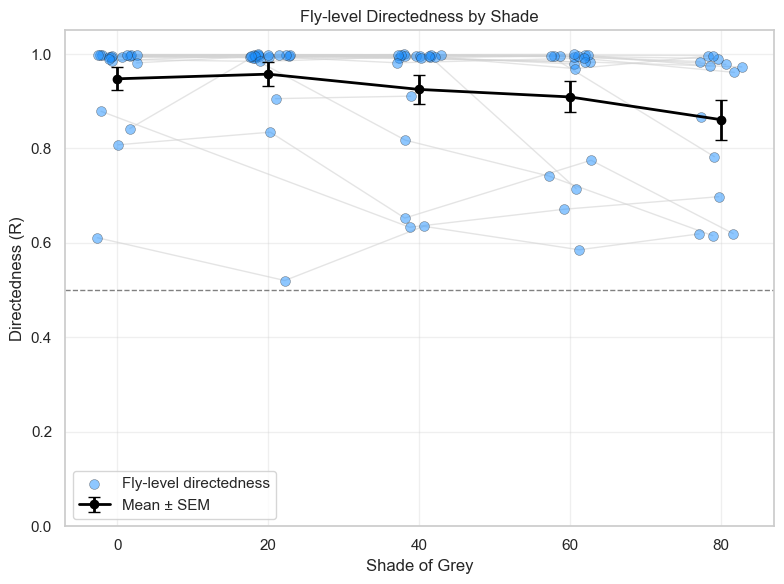

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
df = df_r_per_fly_shade.copy()
shades = sorted(df['shade'].unique())
x_pos_map = {shade: i for i, shade in enumerate(shades)}
df['x_pos'] = df['shade'].map(x_pos_map)

# Add jitter
jitter_strength = 0.15
np.random.seed(42)
df['jittered_x'] = df['x_pos'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df))

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot lines for each FlyID
for fly_id, fly_df in df.groupby('FlyID'):
    ax.plot(
        fly_df['jittered_x'], 
        fly_df['mean_R'], 
        color='lightgray', 
        linewidth=1, 
        alpha=0.6,
        zorder=1
    )

# Plot individual points
ax.scatter(
    df['jittered_x'],
    df['mean_R'],
    color='dodgerblue',
    alpha=0.5,
    edgecolor='k',
    linewidth=0.4,
    s=50,
    label="Fly-level directedness",
    zorder=2
)

# Group means
group_stats = (
    df.groupby('shade')
      .agg(mean=('mean_R', 'mean'),
           sem=('mean_R', lambda x: x.std() / (len(x)**0.5)))
      .reset_index()
)
group_stats['x_pos'] = group_stats['shade'].map(x_pos_map)

# Mean ± SEM
ax.errorbar(
    group_stats['x_pos'],
    group_stats['mean'],
    yerr=group_stats['sem'],
    fmt='-o',
    color='black',
    label='Mean ± SEM',
    capsize=4,
    lw=2,
    zorder=3
)

# Styling
ax.set_xticks(list(x_pos_map.values()))
ax.set_xticklabels(shades)
ax.set_xlabel("Shade of Grey")
ax.set_ylabel("Directedness (R)")
ax.set_title("Fly-level Directedness by Shade")
ax.set_ylim(0, 1.05)
ax.axhline(0.5, color='gray', linestyle='--', linewidth=1)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Assume your solo dataframe is called df_solo
# and the travel direction column is in degrees
df = df_solo.copy()



# Convert to radians
df['travel_dir_rad'] = np.deg2rad(df['TravelDirectionWrapped'])

# Group by FlyID and compute directedness (R)
fly_directedness = df.groupby('FlyID')['travel_dir_rad'].apply(
    lambda x: np.abs(np.mean(np.exp(1j * x)))
).reset_index()

fly_directedness.columns = ['FlyID', 'Directedness_R']

# Sort or analyze as needed
fly_directedness = fly_directedness.sort_values('Directedness_R', ascending=False)


In [ ]:
valid_flies = df.groupby('FlyID')['UniqueTrialID'].nunique()
valid_flies = valid_flies[valid_flies >= 1].index

fly_directedness = fly_directedness[fly_directedness['FlyID'].isin(valid_flies)]


In [ ]:
df_solo['FlyID'].unique()

array(['k4ycmb', 'k4ycbm', 'k4ycmy', 'k4ycyb', 'k4ycmg', 'k4mcmg',
       'k4yccy', 'k4gbcc', 'k4kkbb', 'k4mmbb', 'k4rrmm', 'k4mkww',
       'k4cccg', 'k4mbgm', 'k5kcrm', 'k5cgbm', 'k5kcyy', 'k5kbcy',
       'k3kkcb', 'k3ycbg', 'k3ggcy', 'k3kbkg', 'k3kcmg', 'k3kcrg',
       'k3wwmr', 'k3kcyg', 'k3rcbg', 'k3rcmr', 'k3rcgm', 'k3rcwm',
       'k3ycwg', 'k3wwkm', 'k3rcgw', 'k3rcyg'], dtype=object)

In [ ]:
fly_directedness

,FlyID,Directedness_R
12,k3wwkm,1.000000
26,k4ycmb,1.000000
18,k4kkbb,1.000000
6,k3rcbg,1.000000
0,k3ggcy,0.999387
33,k5kcyy,0.998482
3,k3kcrg,0.997197
21,k4mkww,0.995713
2,k3kcmg,0.994466
7,k3rcgm,0.993733


In [ ]:
from scipy.stats import kruskal
import seaborn as sns

def bootstrap_R(values, n_boot=1000):
    Rs = []
    angles_rad = np.deg2rad(values)
    for _ in range(n_boot):
        sample = np.random.choice(angles_rad, size=len(angles_rad), replace=True)
        R = np.abs(np.mean(np.exp(1j * sample)))
        Rs.append(R)
    return Rs

# Get per-trial data
boot_data = []
for grey in grey_shades:
    subset = df_solo[df_solo['Grey'] == grey]
    per_trial_dir = (
        subset.groupby('UniqueTrialID')['TravelDirectionWrapped']
        .mean()
        .dropna()
    )

    Rs = bootstrap_R(per_trial_dir.values, n_boot=1000)
    boot_data.extend([{'Grey': grey, 'R': r} for r in Rs])

df_boot = pd.DataFrame(boot_data)

# Kruskal-Wallis (nonparametric ANOVA)
groups = [df_boot[df_boot['Grey'] == g]['R'] for g in grey_shades]
stat, pval = kruskal(*groups)
print(f"Kruskal-Wallis H={stat:.3f}, p={pval:.4f}")


Kruskal-Wallis H=3453.899, p=0.0000


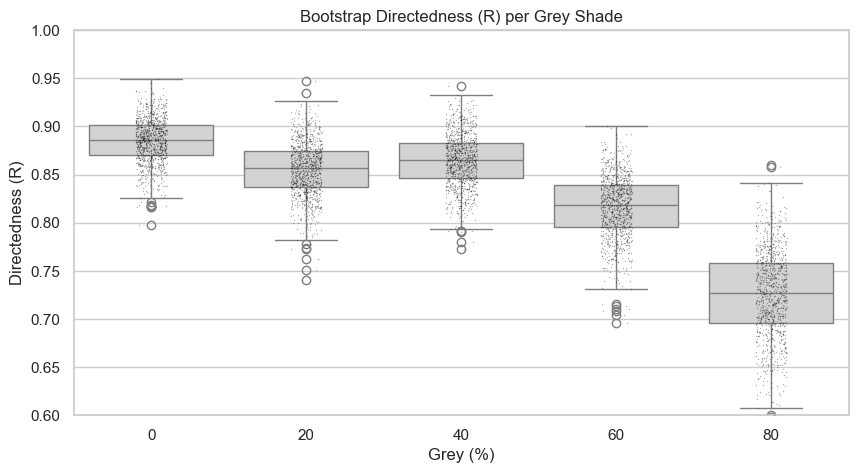

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_boot, x='Grey', y='R', color='lightgray')
sns.stripplot(data=df_boot, x='Grey', y='R', color='black', alpha=0.3, size=1)
plt.title('Bootstrap Directedness (R) per Grey Shade')
plt.ylabel('Directedness (R)')
plt.xlabel('Grey (%)')
plt.ylim(0.6, 1)
plt.show()

/var/folders/fp/69w3242x183607ffnzm682500000gp/T/ipykernel_10846/4074946049.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(['FlyID', 'shade'])


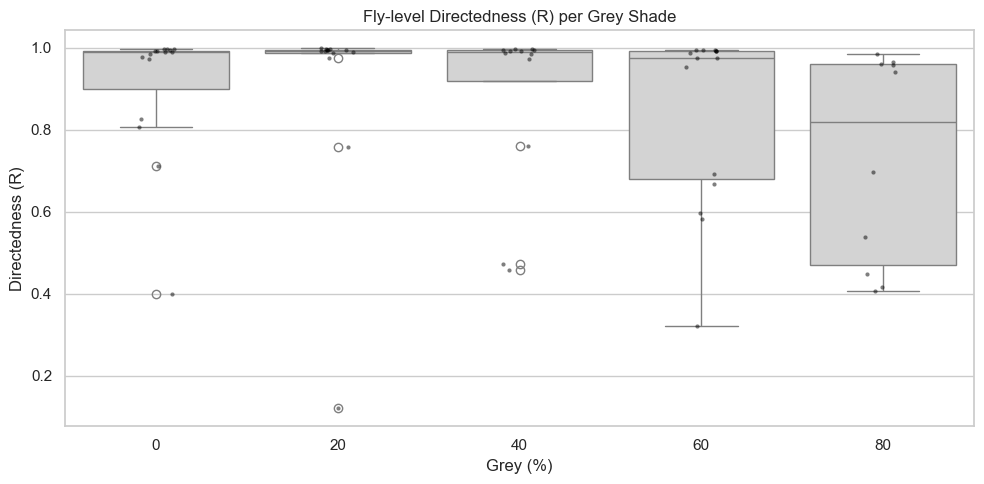

In [ ]:
# Start from original df_solo
df = df_solo.copy()
df['travel_dir_rad'] = np.deg2rad(df['TravelDirectionWrapped'])

# Compute directedness per FlyID per grey shade
df_per_fly = (
    df.groupby(['FlyID', 'shade'])
      .apply(lambda g: np.abs(np.mean(np.exp(1j * g['travel_dir_rad']))))
      .reset_index(name='R')
)

# Optional: Filter only flies with >= N trials per condition
fly_counts = df.groupby(['FlyID', 'shade'])['UniqueTrialID'].nunique()
valid_flys = fly_counts[fly_counts >= 5].reset_index()[['FlyID', 'shade']]
df_per_fly = df_per_fly.merge(valid_flys, on=['FlyID', 'shade'])

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_per_fly, x='shade', y='R', color='lightgray')
sns.stripplot(data=df_per_fly, x='shade', y='R', color='black', alpha=0.5, size=3, jitter=True)
plt.title('Fly-level Directedness (R) per Grey Shade')
plt.ylabel('Directedness (R)')
plt.xlabel('Grey (%)')

plt.tight_layout()
plt.show()
